<a href="https://colab.research.google.com/github/saifulrijal-ds/image-classification-with-DL/blob/main/Keras_CIFAR10_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pada latihan ini kita akan melakukan klasifikasi multi-kelas yaitu mengklasifikasikan gambar ke dalam 10 kelas dengan menggunakan dataset [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html/).

In [81]:
# set random seed
from tensorflow.random import set_seed
set_seed(404)

In [120]:
# import package
import os
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split

%load_ext tensorboard
from tensorboard import notebook

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Get Dataset

In [83]:
(X_train_all, y_train_all), (X_test, y_test) = cifar10.load_data()

X_train dan y_train 'all' karena kita akan membaginya kembali menjadi dataset train dan validasi.

In [84]:
print("X_train.shape:", X_train_all.shape)
print("y_train.shapeL:", y_train_all.shape)

X_train.shape: (50000, 32, 32, 3)
y_train.shapeL: (50000, 1)


In [85]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (10000, 32, 32, 3)
y_test.shape: (10000, 1)


## Explore dataset

In [86]:
# first image in dataset
X_train_all[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

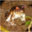

In [87]:
pic = array_to_img(X_train_all[0])
pic

In [88]:
# label index
y_train_all[0][0]

6

Berdasarkan situs [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dan [diskusi](https://github.com/keras-team/keras/issues/2653#issuecomment-217662744) indeks label dibaca 0: airplane, 1: automobile dst.

In [89]:
# variable name
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# label_dict = {}
# for i in range(0, 10):
#   label_dict[i] = label_names[i]

# label_dict

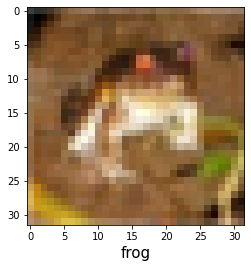

In [90]:
# show image with matplotlib
plt.imshow(X_train_all[0])
plt.xlabel(label_names[y_train_all[0][0]], fontsize=15)
plt.show()

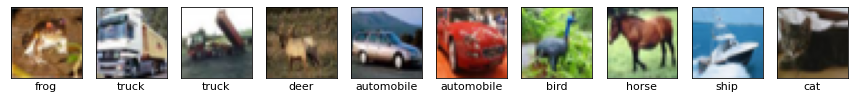

In [91]:
plt.figure(figsize=(15, 5))

for i in range(10):
  plt.subplot(1, 10, i+1)
  # delete x and y tick
  plt.yticks([])
  plt.xticks([])
  plt.xlabel(label_names[y_train_all[i][0]], fontsize=11)
  plt.imshow(X_train_all[i])


Perhatikan penggunaan subplot dan subplots modul matplotlib, index subplot dimulai dari angka 1 bukan 0 sperti pada index objek python yang lain.

In [92]:
X_train_all[0].shape

(32, 32, 3)

In [93]:
n_images, w, h, c = X_train_all.shape
print(f'images = {n_images} \t| width = {w} \t| height = {h} \t | channels = {c}')

images = 50000 	| width = 32 	| height = 32 	 | channels = 3


Sedikit keterangan: 
* width dan height memiliki satuan pixel, 
* channel yang dimaksud adalah color, 3 channel memiliki 3 warna yaitu RGB (Red, Green, dan Blue),
* f sebelum string merupakan salah satu cara pemformatan selain menngunakan metode format() dan %.

## Preprocess Data
karena data berasal dari package Keras sendiri, pada dasarnya data tidak memerlukan terlalu banyak preprocess.  
Yang akan dilakikan adalah:
* Scaling, membagi seluruh nilai dengan nilai 255.0 (nilai maksimum RGB), menghasilkan nilai antara 0 - 1. Hal ini berpengaruh terhadap learning rate, semakin kecil nilai yang dievaluasi (menghitung loss dan menyesuaikan weight).
* Flatten out / meratakan, reshape data dari 4 dimensi menjadi 2 dimensi. Merubah / reshape satu data image 3 dimensi menjadi 1 dimensi. Bentuk awal, 3 dimensi, tidak masalah (tetap bekerja), hanya untuk mempermudah secara konsep untuk merepresentasikan satu image ke dalam satu vektor.
* Membagi data (X_train_all) menjadi data training dan data validation. Hal bertujuan agar proses evaluasi model dapat dilakukan tanpa menggunakan data testing (X_test) tetapi menggunakan data validation, agar penggunaan data testing terkesan lebihi realistis.

In [94]:
type(X_train_all[0][0][0][0])

numpy.uint8

In [95]:
X_train_all, X_test = X_train_all / 255.0, X_test / 255.0

In [96]:
type(X_train_all[0][0][0][0])

numpy.float64

In [97]:
#create variable
image_width = 32
image_height = 32
color_channels = 3
image_pixels = image_width * image_height
total_input = image_pixels * color_channels

In [98]:
X_train_all = X_train_all.reshape(X_train_all.shape[0], total_input)

In [99]:
X_test = X_test.reshape(X_test.shape[0], total_input)

In [100]:
print(f'X_train_all.shape: {X_train_all.shape}')
print(f'X_test.shape: {X_test.shape}')

X_train_all.shape: (50000, 3072)
X_test.shape: (10000, 3072)


#### Create Validation Dataset

In [101]:
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2)

In [102]:
print(f'X_train.shape: {X_train.shape}')
print(f'X_val.shape: {X_val.shape}')

X_train.shape: (40000, 3072)
X_val.shape: (10000, 3072)


In [103]:
# code in tutorial
# X_val = X_train_all[:10000]
# y_val = y_train_all[:10000]

# X_train = X_train_all[10000:]
# y_train = y_train_all[10000:]

#### Cretae small dataset for illustration

In [104]:
X_train_xs = X_train[:1000]
y_train_xs = y_train[:1000]

## Modeling
langkah-langkah dalam membangun sebuah model dalam Tensorflow - Keras:
1. Define, menentukan struktur model yang akan digunakan.
2. Compile, set up lebih lanjut modelnya seperti bagaimana menghitung loss-nya, menghitung penyesuian weights.
3. Fit, training the model

#### Define and compile the neural network using Keras

In [105]:
model_1 = Sequential([
    Dense(units=128, input_dim=total_input, activation='relu', name='m1_hidden1'),
    Dense(units=64, activation='relu', name='m1_hidden2'),
    Dense(units=16, activation='relu', name='m1_hidden3'),
    Dense(units=10, activation='softmax', name='m1_output')
])

model_1.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [121]:
model_2 = Sequential([
    Dropout(0.2, input_shape=(total_input,)),
    Dense(units=128, input_dim=total_input, activation='relu', name='m2_hidden1'),
    Dense(units=64, activation='relu', name='m2_hidden2'),
    Dense(units=16, activation='relu', name='m2_hidden3'),
    Dense(units=10, activation='softmax', name='m1_output')
])

model_2.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [106]:
type(model_1)

tensorflow.python.keras.engine.sequential.Sequential

Terdapat 4 fungsu Dense(), Dense pertama hingga ke tiga menunjukkan hidden layer (input layer direpresentasikan oleh parameter input_dim pada Dense() pertama). Dan Dense keempat merupakan output layer. Jumlah unit pada output layer pada klasifikasi problem ditentukan berdasarkan jumlah kelas label, begitu pula untuk fungsi aktivasinya apakah ia klasifikakasi biner atau multi-kelas.  

_Saya masih belum memahami bagaimana menentukan optimal jumlah layer dan unit pada masih-masing hidden layer, serta fungsi aktivasinya._  

* [Keras Optimizer](https://keras.io/api/optimizers/)
* [Sparse Categorical Cross Entropy - losses function](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class)
* [Metrics](https://keras.io/api/metrics/)

In [107]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m1_hidden1 (Dense)           (None, 128)               393344    
_________________________________________________________________
m1_hidden2 (Dense)           (None, 64)                8256      
_________________________________________________________________
m1_hidden3 (Dense)           (None, 16)                1040      
_________________________________________________________________
m1_output (Dense)            (None, 10)                170       
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


Darimana total parameter dihitung? yaitu dari jumlah koneksi antar neuron ditambahkan dengan jumlah bias, sejumlah neuron pada setiap lapisan (hidden layer).

In [108]:
bias1 = 128
hidden1 = 32*32*3*128 + bias1
bias2 = 64
hidden2 = 128*64 + bias2
bias3 = 16
hidden3 = 64*16 + bias3
bias_output = 10
output = 16*10 + bias_output

hidden1 + hidden2 + hidden3 + output

402810

#### Tensorboard (visualising learning)

In [109]:
# print(datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [110]:
# logdir = os.path.join('/content/drive/My Drive/Image Classification with Deep Learning',
#                       datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [111]:
logdir = os.path.join("logs", datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = TensorBoard(log_dir=logdir)

In [112]:
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(logdir)
)

In [113]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

--2020-10-20 06:19:51--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.21.51.142, 3.209.148.13, 3.90.94.177, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.21.51.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  35.7MB/s    in 0.4s    

2020-10-20 06:19:51 (35.7 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [114]:
get_ipython().system_raw('./ngrok http 6006 &')

In [115]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://dd895a142dbe.ngrok.io


#### Fit the model

In [116]:
%%time

samples_per_batch = 500
nr_epoch = 150
model_1.fit(X_train_xs, 
            y_train_xs, 
            batch_size=samples_per_batch,
            epochs=nr_epoch,
            callbacks=[tensorboard_callback],
            verbose=0,
            validation_data=(X_val, y_val))

CPU times: user 1min 9s, sys: 1.27 s, total: 1min 10s
Wall time: 39.8 s


In [117]:
# %tensorboard --logdir logs

Dari hasi visualisasi tensorboard kita dapat menarik kesimpulan sementara bahwa model mengalami overfitting, dimana sering bertambahnya iterasi akurasi pada data training meningkat namun tidak pada data validation.

Regulerisasi / Regularisation merupakan metode yang digunakan untuk mencegah overfitting. [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) dan [Dropout](https://keras.io/api/layers/regularization_layers/dropout/)

In [122]:
%%time

samples_per_batch = 500
nr_epoch = 150
model_2.fit(X_train_xs, 
            y_train_xs, 
            batch_size=samples_per_batch,
            epochs=nr_epoch,
            callbacks=[tensorboard_callback],
            verbose=0,
            validation_data=(X_val, y_val))

CPU times: user 1min 16s, sys: 1.34 s, total: 1min 17s
Wall time: 43.5 s
